In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils import data

import matplotlib.pyplot as plt
import numpy as np

pytorch document 웹사이트 : https://pytorch.org/docs/stable/index.html

In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [3]:
EPOCHS = 20
BATCH_SIZE = 64

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [5]:
trainset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transform
)

testset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transform
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



In [6]:
train_loader = data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE
)
test_loader = data.DataLoader(
    dataset     = testset,
    batch_size  = BATCH_SIZE
)

In [7]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

(224, 224, 3)


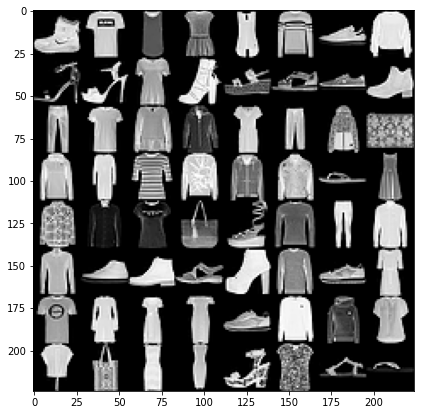

In [8]:
img   = utils.make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize=(7, 7))
plt.imshow(np.transpose(npimg, (1,2,0)))
print(np.transpose(npimg, (1,2,0)).shape)
plt.show()

In [9]:
for i, label in enumerate(labels):
    print("{}".format(label.item()), end=' ')
    if i % 8 == 7:
        print()

9 0 0 3 0 2 7 2 
5 5 0 9 5 5 7 9 
1 0 6 4 3 1 4 8 
4 3 0 2 4 4 5 3 
6 6 0 8 5 2 1 6 
6 7 9 5 9 2 7 3 
0 3 3 3 7 2 2 6 
6 8 3 3 5 0 5 5 


In [10]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}


for i, label in enumerate(labels):
    index = label.item()
    print("{:12}".format(CLASSES[index]), end=' ')
    if i % 8 == 7:
        print()

Ankle boot   T-shirt/top  T-shirt/top  Dress        T-shirt/top  Pullover     Sneaker      Pullover     
Sandal       Sandal       T-shirt/top  Ankle boot   Sandal       Sandal       Sneaker      Ankle boot   
Trouser      T-shirt/top  Shirt        Coat         Dress        Trouser      Coat         Bag          
Coat         Dress        T-shirt/top  Pullover     Coat         Coat         Sandal       Dress        
Shirt        Shirt        T-shirt/top  Bag          Sandal       Pullover     Trouser      Shirt        
Shirt        Sneaker      Ankle boot   Sandal       Ankle boot   Pullover     Sneaker      Dress        
T-shirt/top  Dress        Dress        Dress        Sneaker      Pullover     Pullover     Shirt        
Shirt        Bag          Dress        Dress        Sandal       T-shirt/top  Sandal       Sandal       


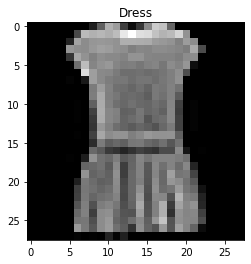

In [11]:
idx = 3

item_img = images[idx]
item_npimg = item_img.squeeze().numpy()
plt.title(CLASSES[labels[idx].item()])
plt.imshow(item_npimg, cmap='gray')
plt.show()

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))

        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [13]:
# Model을 GPU에 얹어줌

model = Net().to(DEVICE)

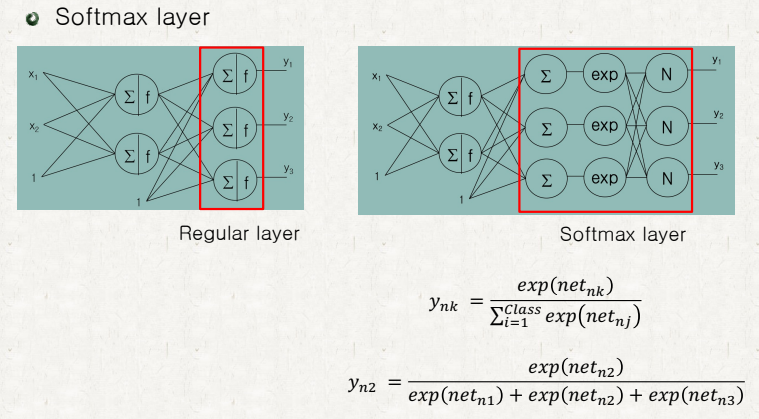

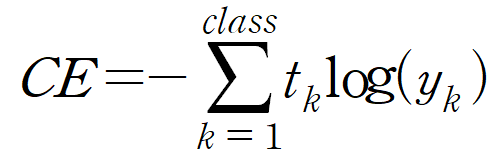

In [14]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma = 0.1)

In [15]:
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

In [16]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()
            pred = output.max(dim=1)[1]
            correct += pred.eq(target).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [17]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

[1] Test Loss: 0.8446, Accuracy: 68.05%
[2] Test Loss: 0.6752, Accuracy: 76.11%
[3] Test Loss: 0.5973, Accuracy: 79.28%
[4] Test Loss: 0.5598, Accuracy: 80.08%
[5] Test Loss: 0.5371, Accuracy: 80.75%
[6] Test Loss: 0.5202, Accuracy: 81.23%
[7] Test Loss: 0.5073, Accuracy: 81.65%
[8] Test Loss: 0.4957, Accuracy: 82.21%
[9] Test Loss: 0.4850, Accuracy: 82.67%
[10] Test Loss: 0.4760, Accuracy: 83.00%
[11] Test Loss: 0.4670, Accuracy: 83.32%
[12] Test Loss: 0.4592, Accuracy: 83.57%
[13] Test Loss: 0.4521, Accuracy: 83.88%
[14] Test Loss: 0.4447, Accuracy: 84.23%
[15] Test Loss: 0.4388, Accuracy: 84.46%
[16] Test Loss: 0.4326, Accuracy: 84.72%
[17] Test Loss: 0.4266, Accuracy: 84.98%
[18] Test Loss: 0.4209, Accuracy: 85.13%
[19] Test Loss: 0.4169, Accuracy: 85.34%
[20] Test Loss: 0.4128, Accuracy: 85.43%


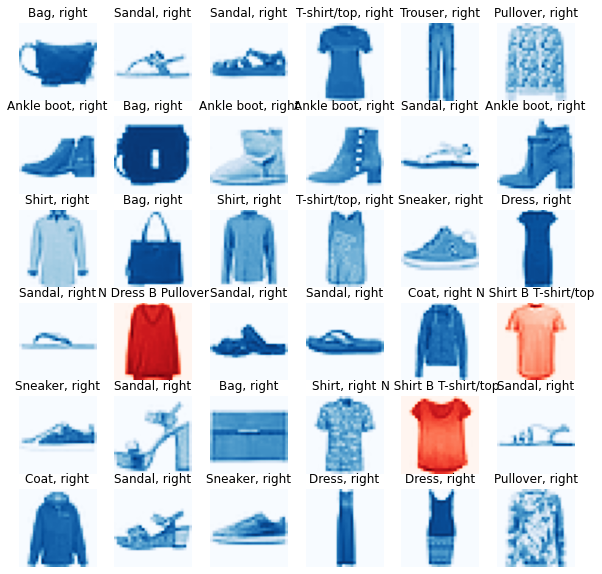

In [18]:
# 결과 시각화

columns = 6
rows = 6
fig = plt.figure(figsize=(10,10))
 
model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(testset))
    input_img = testset[data_idx][0].unsqueeze(dim=0).to(DEVICE) 
 
    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = CLASSES[argmax.item()]
    label = CLASSES[testset[data_idx][1]]
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + ', right')
        cmap = 'Blues'
    else:
        plt.title('N ' + pred + ' B ' +  label)
        cmap = 'Reds'
    plot_img = testset[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')
    
plt.show() 